<p style="font-size:200%;font-weight:bold"> Fuzzy Matching </p>

- re.sub('[\(\[].*[\)\]]', '', s) 为什么是reprisk特有pattern
- 为什么正则表达式一定要用triple quote， 因为有'和"了是么

In [2]:
import re
#正则表达式
import heapq
#堆队列算法

import pandas as pd
import numpy as np
import jellyfish
from pandarallel import pandarallel
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'
pandarallel.initialize(progress_bar=True, nb_workers=6)

DB = '/home/data/'
ROOT = '/home/team_crypto/2022_esg_peer/'

RD = f'{ROOT}02_rdata/'
WD = f'{ROOT}03_wdata/'

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
df= pd.read_parquet(f'{WD}reprisk_compustat.pq')
df.shape
df.sample(3)

(830760, 12)

,RepRisk_ID,date,current_RRI,name,all_ISINs,primary_ISIN,headquarter_country_code,iscu,tic,cusip,conm,_merge
453785,40063,2008-06-30,0,Costa Inc (formerly AT Cross Co),US22149T1025,US22149T1025,US,22149T10,ATX,22149T102,COSTA INC -CL A,both
146722,131666,2011-11-30,0,Endeavor Energy Resources LP,US29260FAF71 US29260FAB67 US29260FAC41 US29260...,US29260FAA84,US,29260FAA,None,None,None,left_only
482693,44039,2009-06-30,0,ReShape Lifesciences Inc (formerly EnteroMedic...,None,US7611236032,US,76112360,None,None,None,left_only


In [13]:
cp = pd.read_csv(f'{RD}comp_na_daily_all.csv')
cp.shape
cp.sample(3)

(587111, 14)

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,curcd,at,costat,conml
153552,7993,19781231,1978.0,INDL,C,D,STD,NWN,66765N105,NORTHWEST NATURAL HLDNG CO,USD,266.873,A,Northwest Natural Holding Co
42960,2960,20171231,2017.0,INDL,C,D,STD,CHE,16359R103,CHEMED CORP,USD,920.026,A,Chemed Corp
54319,3473,19671231,1967.0,INDL,C,D,STD,CTC.1,210902102,CONTEL CORP,USD,692.400,I,Contel Corp


In [14]:
PUNC = ''' |,|\.|;|:|\||\(|\)|&|'|"''' #|代表either; 少打了一个‘ ’导致错误; 三引号支持字符串跨多行

REMOVE = [
    '', 'inc', 'fund', 'ltd', 'plt',
    'corporation', 'corp', 'group', 'holdings',
    'co', 'sa', 'cv', 'llc', 'de', 'the', 'holding', 'na', 'usa',
    'bv', 'holdco', 'lp', 'plc', 'etf', 'ab', 'and', 'nv',
    'equity', 'enterprises'
]

REPLACE = {                              #可以理解为创建了一个映射
    'bancorp': 'bank',
    'banc': 'bank',
    'biotechnologies': 'biotech',
    'biotechnology': 'biotech',
    'technologies': 'tech',
    'technology': 'tech'
}

def clean_name(s):
    s = s.lower()     #变成小写
    s = re.sub('[\(\[].*[\)\]]', '', s)   #Delete pattern 反斜杠\用来调用特殊字符但不调用其特殊含义; []其中可以将字母担单独分开并且使特殊符号失去含义 
    #去除了括号里的内容 把上述语句拆分就是 [ \( \[ ]  .* [ \) \] ]; .*代表匹配除换行符以外的所有字符
    ws = re.split(PUNC, s)                #用pattern来分成一个list
    ws = [w for w in ws if w not in REMOVE] #if决定了for是否运行 for 后置必须以list[]的形式出现
    return ' '.join([w if w not in REPLACE else REPLACE[w] for w in ws]) #in / not in 检验sequence(string,list..)的组成成分; join用某个字符链接list里的所有字符
                                                                        #for后置顺序颠倒
clean_name('Indianapolis Power & Light Co (IPL; IPALCO)')
clean_name('Pinnacle Banc Group Inc')

'indianapolis power light'

'pinnacle bank'

# Reprisk

In [15]:
df2 = df.loc[df['_merge'] == 'left_only', ['RepRisk_ID', 'name']].drop_duplicates()
df2.shape
df2.sample(3)

(1418, 2)

,RepRisk_ID,name
303072,20119,Ocean Spray Cranberries Inc
747264,86072,PDX Partners Inc (formerly My Social Income In...
239064,167921,OneMain Financial Inc (formerly CitiFinancial)


In [16]:
df2['namec'] = df2['name'].apply(clean_name)
df2.sample(3)

,RepRisk_ID,name,namec
76272,116062,Kaiser Foundation Hospitals Inc,kaiser foundation hospitals
701064,79172,Patriot Renewable Fuels LLC,patriot renewable fuels
764064,88973,Cannonau Corp (formerly Pacific Blue Energy Corp),cannonau


In [17]:
df2['namec'].duplicated().sum()

16

In [18]:
df2.loc[df2['namec'].duplicated()].sample()

,RepRisk_ID,name,namec
85344,1175730,Kmart Holding Corp,kmart


In [19]:
df2.loc[df2['namec'] == 'solarwinds']

,RepRisk_ID,name,namec
386736,31141,SolarWinds Inc,solarwinds
514248,487182,SolarWinds Corp,solarwinds


In [20]:
cands = set(df2['namec'])

# Compustat

In [21]:
matched = set(df.loc[df['cusip'].notna(), 'cusip'])
len(matched)

3527

In [22]:
cp2 = cp.loc[~cp['cusip'].isin(matched), ['gvkey', 'conm', 'conml']].drop_duplicates() #~补码/取反
cp2.shape
cp2.sample(3)

(38084, 3)

,gvkey,conm,conml
33231,2521,REUNION INDUSTRIES INC,Reunion Industries Inc
369046,27338,APTEVO THERAPEUTICS INC,Aptevo Therapeutics Inc
574040,186080,NULEGACY GOLD CORP,NuLegacy Gold Corp


In [23]:
cp2['namec'] = cp2['conml'].apply(clean_name)
cp2.sample(10)

,gvkey,conm,conml,namec
369490,27522,ID BIOMEDICAL CORP,ID Biomedical Corp,id biomedical
351862,24912,ACORN ENERGY INC,Acorn Energy Inc,acorn energy
124654,6693,LEWIS (PALMER G.) CO INC,Lewis (Palmer G.) Co Inc,lewis
372746,27972,MICROCAP LIQUIDATING TRUST,Microcap Liquidating Trust,microcap liquidating trust
472448,110166,PAN ORIENT ENERGY CORP,Pan Orient Energy Corp,pan orient energy
391770,29870,OLYMPIC STEEL INC,Olympic Steel Inc,olympic steel
144712,7614,MULTI-TECH CORP,Multi-Tech Corp,multi-tech
60423,3764,DATA 100 CORP,Data 100 Corp,data 100
471982,109764,INDUSTRIAL RUBBER PRODS INC,Industrial Rubber Products Inc,industrial rubber products
578711,187765,ECOSYNTHETIX INC,ECOSYNTHETIX Inc,ecosynthetix


# Match

In [24]:
def match_top(s, candidates, n=1, method='lev'):
    heap = [(-np.Inf, '') for _ in range(n)]
    heapq.heapify(heap) #将list转化成堆
    
    for t in candidates:
        l = len(t)
        if method == 'lev':
            score = jellyfish.levenshtein_distance(s, t) / max(l, len(s)) - 1
        elif method == 'dam_lev':
            score = jellyfish.damerau_levenshtein_distance(s, t) / max(l, len(s)) - 1
        elif method == 'jaro':
            score = -jellyfish.jaro_distance(s, t)
        elif method == 'jaro_win':
            score = -jellyfish.jaro_winkler_similarity(s, t) 
        
        heapq.heappushpop(heap, (-score, t)) #将 item 放入堆中，然后弹出并返回 heap 的最小元素
        
    heap.sort(reverse=True) #求最大值
    return heap

In [3]:
[(-np.Inf, '') for _ in range(2)] #_为任意变量

[(-inf, ''), (-inf, '')]

In [26]:
jellyfish.jaro_winkler_similarity('asd', 'asd2')
jellyfish.jaro_winkler_similarity('asd', 'asd')

0.9416666666666667

1.0

In [27]:
%time
cp2['match'] = cp2['namec'].parallel_apply(lambda x: match_top(x, cands, 3, 'jaro_win'))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [28]:
cp2['match1'], cp2['match2'], cp2['match3'] = zip(*list(cp2['match'].values))
#zip让[(a, A), (b, B), (c, C)]拆分成(a, b, c)和(A, B, C) 适用于拆分由函数return的list
#要输出的时候+解包的时候才必须用list

In [44]:
a = [1, 2, 3]
b = [4, 5, 6]
zipped = zip(a, b)
zipped
ziplist = list(zipped)
ziplist
a, b = list(zip(*ziplist))
a
b
#zip让[(a, A), (b, B), (c, C)]拆分成(a, b, c)和(A, B, C) 适用于拆分由函数return的list

[(1, 4), (2, 5), (3, 6)]

(1, 2, 3)

(4, 5, 6)

In [30]:
for i in range(3):
    i += 1
    cp2[f'score{i}'], cp2[f'm_namec{i}'] = zip(*list(cp2[f'match{i}'].values)) #*为解包运算符
cp2.sample(3)

,gvkey,conm,conml,namec,match,match1,match2,match3,score1,m_namec1,score2,m_namec2,score3,m_namec3
561722,180665,DRONE AVIATION HOLDING -OLD,Drone Aviation Holding Corp -OLD,drone aviation -old,"[(0.7368421052631579, rovi), (0.72823261858349...","(0.7368421052631579, rovi)","(0.7282326185834957, kaiser foundation hospitals)","(0.722132253711201, rki exploration production)",0.736842,rovi,0.728233,kaiser foundation hospitals,0.722132,rki exploration production
361433,25845,MKTG INC,mktg Inc,mktg,"[(0.7222222222222222, kcg), (0.666666666666666...","(0.7222222222222222, kcg)","(0.6666666666666666, phh mortgage)","(0.6666666666666666, mtbc)",0.722222,kcg,0.666667,phh mortgage,0.666667,mtbc
416072,36974,EVOLVE FUTURE LEADERSHI FUND,Evolve Future Leadership Fund,evolve future leadership,"[(0.6682539682539682, universal city developme...","(0.6682539682539682, universal city developmen...","(0.6666666666666666, general electric)","(0.665954415954416, providence health services)",0.668254,universal city development partners,0.666667,general electric,0.665954,providence health services


In [31]:
cp3 = cp2.drop(columns=[x for x in cp2.columns if 'match' in x]) #columns可以替代keys的写法; x for x in ... if ....的语法
cp3.sample(3)

,gvkey,conm,conml,namec,score1,m_namec1,score2,m_namec2,score3,m_namec3
416650,37480,908 DEVICES INC,908 Devices Inc,908 devices,0.668998,servicemaster,0.659596,directview,0.641414,edp escelsa
160140,8282,PACIFIC SOUTHERN MORTGAGE TR,Pacific Southern Mortgage Trust,pacific southern mortgage trust,0.838065,pacificorp,0.731494,california resources,0.714935,stonemor partners
16887,1787,ARWOOD CORP,Arwood Corp,arwood,0.800000,agrokor dd,0.752778,crawford,0.750000,amiworld


<AxesSubplot:>

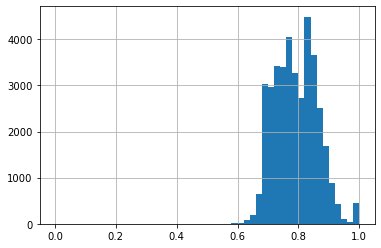

In [32]:
cp3['score1'].hist(bins=50)

In [33]:
cp3.loc[cp3['score1'] == 1].shape
cp3.loc[cp3['score1'].between(0.95, 0.99, inclusive='neither')].shape

(440, 10)

(64, 10)

In [34]:
cp3.loc[cp3['score1'].between(0.95, 0.99, inclusive='neither')]

,gvkey,conm,conml,namec,score1,m_namec1,score2,m_namec2,score3,m_namec3
151,1010,ACF INDUSTRIES INC,ACF Industries Inc,acf industries,0.976190,cf industries,0.837229,ace securities,0.767507,global industrial
7068,1331,ALPINE GROUP INC,Alpine Group Inc,alpine,0.952381,calpine,0.822222,linde,0.730159,dolphin energy
7418,1356,ALCOA INC,Alcoa Inc,alcoa,0.960000,alco,0.840000,acosta,0.822222,valcom
10354,1489,AMERICAN INVESTMENT CO,American Investment Co,american investment,0.958333,american investment life,0.874422,american addiction centers,0.869649,american retail
11541,1548,AMERICAN RENT-ALL INC,American Rent-All Inc,american rent-all,0.951373,american retail,0.892661,american realty funds,0.879919,american residential services
...,...,...,...,...,...,...,...,...,...,...
559840,179846,MHP S.E,MHP S.E,mhp s e,0.971429,mhp se,0.699634,macy s retail,0.681139,merck sharp dohme
561373,180471,DAVE & BUSTER'S HLDINGS-REDH,Dave & Buster's Holdings Inc,dave buster s,0.984615,dave busters,0.822122,davey tree expert,0.755055,dolat ventures
564344,183078,ENVIRORESOLUTIONS INC,EnviroResolutions Inc,enviroresolutions,0.976471,envirosolutions,0.766214,profile solutions,0.766214,navient solutions
571566,185326,UCI INTERNATIONAL INC,UCI International Inc,uci international,0.960784,cpi international,0.899346,hub international,0.847816,columbus international
